In [1]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
year = 20
pred_csv = f"./output/donors_state{year}_pred_lastname.csv"
donors_csv = f"./data/CampaignFin{year}/donors_recip{year}.csv"
cands_csv = f"./data/CampaignFin{year}/cands{year}.txt"

In [3]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,recip_id,name,name_new,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation
0,U00000037041,N00029349,"BLOOMBERG, MICHAEL R",michael r bloomberg,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,1.086565e+09,868,1.251802e+06,612.0
1,U00000036521,N00044966,"STEYER, TOM",tom steyer,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,3.179460e+08,582,5.462989e+05,2036.5
2,,N00001669,"INFORMATION REQUESTED, INFORMATION",information information requested,Y4000,,NaN,NaN,NEW YORK,CA,9.947018e+07,589,1.688798e+05,250.0
3,,C00484642,MAJORITY FORWARD,majority forward majority forward,Z9600,,NaN,NaN,WASHINGTON,DC,9.866908e+07,122,8.087629e+05,117035.5
4,,C00618371,WINRED,winred winred,Z9600,,NaN,NaN,ARLINGTON,VA,9.195982e+07,197,4.668011e+05,500.0
5,,C00571703,CHEVRON CORPORATION,koch industries inc koch industries inc,Y4000,,NaN,NaN,WASHINGTON,TX,6.460129e+07,212,3.047231e+05,50000.0
6,,C00495028,CHC BOLD PAC,chc bold pac chc bold pac,Z9600,,NaN,NaN,WASHINGTON,DC,5.408387e+07,207,2.612747e+05,70000.0
7,,C00693382,FUND FOR POLICY REFORM,fund for policy reform fund for policy reform,J1200,,NaN,NaN,WILMINGTON,DE,4.950000e+07,7,7.071429e+06,6000000.0
8,,C00669259,FUTURE FORWARD USA ACTION,future forward usa action future forward usa a...,J1200,,NaN,NaN,WASHINGTON,DC,4.526326e+07,27,1.676417e+06,100000.0
9,,C00504530,AMERICAN ACTION NETWORK,american action network american action network,Z9600,,NaN,NaN,WASHINGTON,DC,4.465169e+07,138,3.235630e+05,100000.0


In [4]:
cands_lf = (
        pl.scan_csv(
            cands_csv,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'id', 'recip_id', 'name', 'party', 
                        'seat', 'seat_current', 'ran_general', 'ran_ever', 'type', 
                        'recipcode', 'nopacs'],
            ignore_errors=True
        )
        .select(['id', 'recip_id', 'name', 'party', 'seat', 'seat_current', 
                 'ran_general', 'ran_ever', 'type', 'recipcode'])
    )

cands = cands_lf.collect()
cands = cands.to_pandas()
cands = cands.drop_duplicates(subset=['recip_id', 'name', 'party', 'seat'], keep='last')
cands[(cands["seat"] == "PRES") & (cands["ran_general"] == "Y")]

,id,recip_id,name,party,seat,seat_current,ran_general,ran_ever,type,recipcode
6211,P00013524,N00011042,Jo Jorgensen (L),L,PRES,,Y,Y,C,3L
6278,P00014209,N00042370,Don Blankenship (3),3,PRES,,Y,Y,C,3L
6934,P80000722,N00001669,Joe Biden (D),D,PRES,,Y,Y,C,DW
6936,P80001571,N00023864,Donald Trump (R),R,PRES,PRES,Y,Y,I,RL


In [5]:
cands[cands["recip_id"].str.contains("N")]

,id,recip_id,name,party,seat,seat_current,ran_general,ran_ever,type,recipcode
0,H0AK00105,N00039029,Thomas Lamb (I),I,AK01,,,Y,C,3N
1,H0AK00113,N00047445,Ray Sean Tugatuk (D),D,AK01,,,Y,C,DL
3,H0AL01055,N00044245,Jerry Carl (R),R,AL01,,Y,Y,O,RW
4,H0AL01063,N00044288,Wes Lambert (R),R,AL01,,,Y,O,RL
5,H0AL01071,N00025369,Chris Pringle (R),R,AL01,,,Y,O,RL
...,...,...,...,...,...,...,...,...,...,...
8055,S8WV00135,N00041474,Bo Copley (R),R,WVS1,,,,,RN
8056,S8WV00143,N00012642,Patrick Morrisey (R),R,WVS1,,,,,RN
8057,S8WY00189,N00027793,Gary Trauner (D),D,WYS1,,,,,DN
8058,S8WY00197,N00042998,David Dodson (R),R,WYS1,,,,,RN


In [6]:
mapping = {
    'A': 'Agribusiness',
    'B': 'Construction',
    'C': 'Tech',
    'D': 'Defense',
    'E': 'Energy',
    'F': 'Finance',
    'M': 'Misc Business',
    'H': 'Health',
    'J': 'Ideology/Single Issue',
    'K': 'Law',
    'L': 'Labor',
    'M': 'Manufacturing',
    'T': 'Transportation',
    'W': 'Other',
    'Y': 'Unknown',
    'Z': 'Party'
}

donors["sector"] = donors["realcode"].apply(lambda x: str(x).upper()[0]).map(mapping)
donors["sector"].value_counts()

sector
Party                    1299587
Unknown                  1036328
Ideology/Single Issue     861610
Health                    541522
Finance                   443132
Tech                      224719
Law                       199207
Construction              122016
Transportation            118605
Labor                     112626
Energy                     89268
Agribusiness               73594
Manufacturing              55259
Defense                    37952
Name: count, dtype: int64

In [7]:
preds = pd.read_csv(pred_csv)
donors = donors.merge(preds[['contrib_id', 'ethnic']], on='contrib_id', how='left')
donors = donors.merge(cands, on='recip_id', how='left')

In [8]:
contrib_party_totals = (
    donors.groupby(['contrib_id', 'name_new', 'party'])['total_donated']
    .sum()
    .unstack()
    .fillna(0)
)

contrib_party_totals['dem_ratio'] = (
    contrib_party_totals.get('D', 0) / 
    (contrib_party_totals.get('D', 0) + contrib_party_totals.get('R', 0))
)

donors = donors.merge(
    contrib_party_totals['dem_ratio'].reset_index(),
    on=['contrib_id', 'name_new'],
    how='left'
)

donors

,contrib_id,recip_id,name_x,name_new,realcode,gender,occupation,employer,city,state,...,id,name_y,party,seat,seat_current,ran_general,ran_ever,type,recipcode,dem_ratio
0,U00000037041,N00029349,"BLOOMBERG, MICHAEL R",michael r bloomberg,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,...,P00014530,Michael Bloomberg (D),D,PRES,,,Y,C,DL,1.0
1,U00000036521,N00044966,"STEYER, TOM",tom steyer,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,...,P00012716,Tom Steyer (D),D,PRES,,,Y,C,DL,1.0
2,,N00001669,"INFORMATION REQUESTED, INFORMATION",information information requested,Y4000,,NaN,NaN,NEW YORK,CA,...,P80000722,Joe Biden (D),D,PRES,,Y,Y,C,DW,1.0
3,,C00484642,MAJORITY FORWARD,majority forward majority forward,Z9600,,NaN,NaN,WASHINGTON,DC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,,C00618371,WINRED,winred winred,Z9600,,NaN,NaN,ARLINGTON,VA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7136705,h3001209792,N00040675,"GOULD, COLIN",colin gould,C5120,M,SOFTWARE INFRASTRUCTURE ARCHITECT,ORACLE,FOSTER CITY,CA,...,S8GA00180,Jon Ossoff (D),D,GAS1,,Y,Y,C,DW,1.0
7136706,p0001372401,C00003418,"BLEDSOE, PEARLIOUS MS",pearlious ms bledsoe,X1200,F,RETIRED,RETIRED,GRANITEVILLE,SC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7136707,r0006423692,C00003418,"CARMICHAEL, RUTH",ruth carmichael,X1200,F,RETIRED,RETIRED,KANSAS CITY,KS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7136708,r0015995400,C00003418,"BOOKATZ, DEBRA MRS",debra mrs bookatz,Y4000,F,RETIRED,MARINE CORP. COMMUNITY SERVICES,KANEOHE,HI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
donors["level"] = donors["seat"].apply(lambda x: "Senate" if "S1" in str(x) or "S2" in str(x) else "President" if str(x) == "PRES" else "House" if type(x) == str and len(str(x)) == 4 else "Unknown")
donors["level"].value_counts()

level
Unknown      3447415
Senate       1462833
President    1380460
House         846002
Name: count, dtype: int64

In [10]:
def read_and_process_donors_csv(year):
    
    # define files
    pred_csv = f"./output/donors_state{year}_pred_lastname.csv"
    donors_csv = f"./data/CampaignFin{year}/donors_recip{year}.csv"
    cands_csv = f"./data/CampaignFin{year}/cands{year}.txt"
    
    # read donors csv
    donors = pd.read_csv(donors_csv)
    
    # read cands csv
    cands_lf = (
        pl.scan_csv(
            cands_csv,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'id', 'recip_id', 'name', 'party', 
                        'seat', 'seat_current', 'ran_general', 'ran_ever', 'type', 
                        'recipcode', 'nopacs'],
            ignore_errors=True
        )
        .select(['id', 'recip_id', 'name', 'party', 'seat', 'seat_current', 
                 'ran_general', 'ran_ever', 'type', 'recipcode'])
    )

    cands = cands_lf.collect()
    cands = cands.to_pandas()
    cands = cands.drop_duplicates(subset=['recip_id', 'name', 'party', 'seat'], keep='last')
    
    # map sectors
    donors["sector"] = donors["realcode"].apply(lambda x: str(x).upper()[0]).map(mapping)
    
    # merge the three csvs
    preds = pd.read_csv(pred_csv)
    donors = donors.merge(preds[['contrib_id', 'ethnic']], on='contrib_id', how='left')
    donors = donors.merge(cands, on='recip_id', how='left')
    
    # calculate dem ratio
    contrib_party_totals = (
        donors.groupby(['contrib_id', 'name_new', 'party'])['total_donated']
        .sum()
        .unstack()
        .fillna(0)
    )

    contrib_party_totals['dem_ratio'] = (
        contrib_party_totals.get('D', 0) / 
        (contrib_party_totals.get('D', 0) + contrib_party_totals.get('R', 0))
    )

    donors = donors.merge(
        contrib_party_totals['dem_ratio'].reset_index(),
        on=['contrib_id', 'name_new'],
        how='left'
    )
    
    # map levels
    donors["level"] = donors["seat"].apply(lambda x: "Senate" if "S1" in str(x) or "S2" in str(x) else 
                                           "President" if str(x) == "PRES" else 
                                           "House" if type(x) == str and len(str(x)) == 4 else 
                                           "Unknown")
    
    # add electoral cycle    
    donors["cycle"] = f"20{year}"

    return donors

In [11]:
all_donors = donors
all_donors["cycle"] = f"20{year}"

for year in tqdm(list(filter(lambda x: x != year, ["08", 10, 12, 14, 16, 18, 20, 22]))):
    
    donors = read_and_process_donors_csv(year)
    all_donors = pd.concat([all_donors, donors], ignore_index=True)
    
all_donors["cycle"].value_counts()

100%|██████████| 7/7 [03:47<00:00, 32.44s/it]


cycle
2020    7136710
2022    6014905
2016    3884782
2018    3150099
2012    2369349
2008    2258928
2010    1358567
2014    1261851
Name: count, dtype: int64

In [12]:
all_donors

,contrib_id,recip_id,name_x,name_new,realcode,gender,occupation,employer,city,state,...,party,seat,seat_current,ran_general,ran_ever,type,recipcode,dem_ratio,level,cycle
0,U00000037041,N00029349,"BLOOMBERG, MICHAEL R",michael r bloomberg,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,...,D,PRES,,,Y,C,DL,1.0,President,2020
1,U00000036521,N00044966,"STEYER, TOM",tom steyer,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,...,D,PRES,,,Y,C,DL,1.0,President,2020
2,,N00001669,"INFORMATION REQUESTED, INFORMATION",information information requested,Y4000,,NaN,NaN,NEW YORK,CA,...,D,PRES,,Y,Y,C,DW,1.0,President,2020
3,,C00484642,MAJORITY FORWARD,majority forward majority forward,Z9600,,NaN,NaN,WASHINGTON,DC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,2020
4,,C00618371,WINRED,winred winred,Z9600,,NaN,NaN,ARLINGTON,VA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Unknown,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27435186,r0014337648,C00401224,"FISKE, MARGARET",margaret fiske,Z9500,F,NaN,NaN,SAN GABRIEL,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,2022
27435187,m0001511409,C00401224,"POLLNOW, RITA",rita pollnow,Z9500,F,NaN,NaN,DAVIS,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Unknown,2022
27435188,r0007056936,C00003418,"MILLER, GLENN MR JR",glenn mr jr miller,X1200,M,RETIRED,RETIRED,OMAHA,NE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,2022
27435189,q0001809165,C00401224,"CAMOBELL, JEANINE",jeanine camobell,Z9500,F,NaN,NaN,PLEASANT VALLEY,NY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,2022


In [13]:
agg_all = all_donors.groupby('cycle')['total_donated'].agg(['mean', 'median']).reset_index()
agg_all['group'] = 'All Donors'
agg_indian = all_donors[all_donors['ethnic'] == 'ind'].groupby('cycle')['total_donated'].agg(['mean', 'median']).reset_index()
agg_indian['group'] = 'Indian-American Donors'

combined = pd.concat([agg_all, agg_indian])

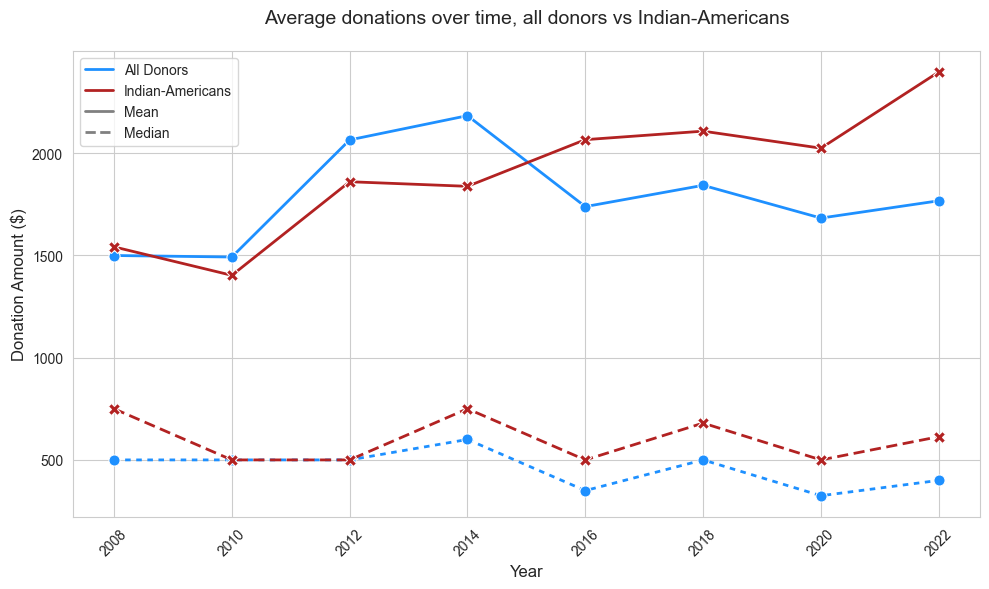

In [14]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.lineplot(
    data=combined, x='cycle', y='mean', hue='group',
    style='group', markers=True, dashes=False,
    palette=['dodgerblue', 'firebrick'],
    linewidth=2, marker='o', markersize=8
)
sns.lineplot(
    data=combined, x='cycle', y='median', hue='group',
    style='group', markers=True, dashes=[(2,2), (4,2)],
    palette=['dodgerblue', 'firebrick'],
    linewidth=2, marker='s', markersize=8,
    legend=False
)

plt.title('Average donations over time, all donors vs Indian-Americans', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Donation Amount ($)', fontsize=12)
plt.xticks(rotation=45)

legend_elements = [
    Line2D([0], [0], color='dodgerblue', lw=2, label='All Donors'),
    Line2D([0], [0], color='firebrick', lw=2, label='Indian-Americans'),
    Line2D([0], [0], color='gray', lw=2, linestyle='-', label='Mean'),
    Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Median')
]
plt.legend(handles=legend_elements, loc='upper left', frameon=True)

plt.tight_layout()
plt.show()

In [15]:
sector_counts_all = (
    all_donors[~all_donors["sector"].isin(["Unknown", "Party", "Ideology/Single Issue"])]
    .groupby(['cycle', 'sector'])
    .size()
    .unstack(fill_value=0)
)

sector_counts_indian = (
    all_donors[~all_donors["sector"].isin(["Unknown", "Party", "Ideology/Single Issue"])][all_donors["ethnic"] == "ind"]
    .groupby(['cycle', 'sector'])
    .size()
    .unstack(fill_value=0)
)

sector_pct_all = sector_counts_all.div(sector_counts_all.sum(axis=1), axis=0) * 100
sector_pct_indian = sector_counts_indian.div(sector_counts_indian.sum(axis=1), axis=0) * 100

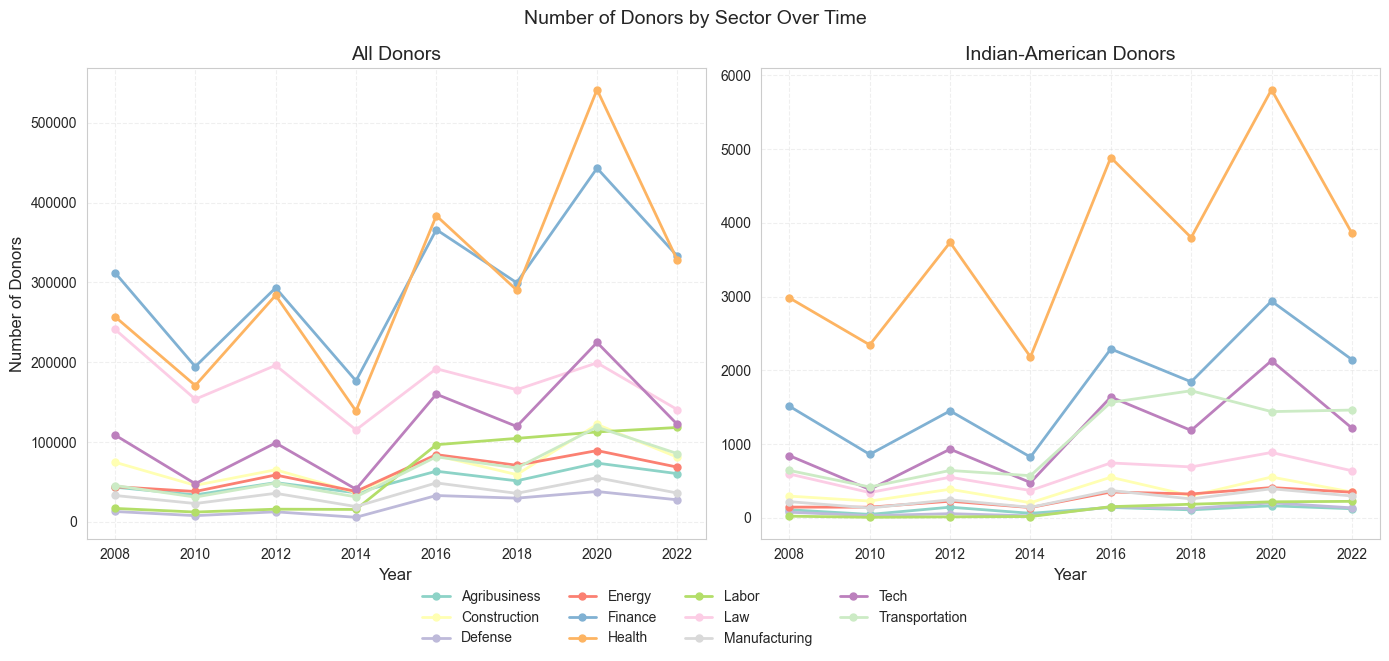

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
colors = sns.color_palette("Set3", n_colors=len(sector_counts_all.columns))

for i, sector in enumerate(sector_counts_all.columns):
    ax1.plot(
        sector_counts_all.index,
        sector_counts_all[sector],
        label=sector,
        color=colors[i],
        marker='o',
        markersize=5,
        linewidth=2
    )

ax1.set_title("All Donors", fontsize=14)
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Number of Donors", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.3)

for i, sector in enumerate(sector_counts_indian.columns):
    ax2.plot(
        sector_counts_indian.index,
        sector_counts_indian[sector],
        label=sector,
        color=colors[i],
        marker='o',
        markersize=5,
        linewidth=2
    )

ax2.set_title("Indian-American Donors", fontsize=14)
ax2.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Number of Donors", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=10,
    frameon=False
)

plt.suptitle("Number of Donors by Sector Over Time", fontsize=14)
plt.tight_layout()
plt.show()

In [17]:
sector_counts_all

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2008,43390,74691,12946,44061,312336,257180,16810,241263,33002,108826,45497
2010,33694,45710,7728,38010,194534,170823,12243,153620,22940,47738,30992
2012,49134,65195,12533,58667,293205,283803,15833,196055,35715,98864,48598
2014,36398,36542,5679,38104,176674,138896,15503,115235,19128,40889,31252
2016,63413,82885,32948,84184,366169,383578,96632,191864,48753,159959,81459
2018,51386,59168,29669,70868,299623,290450,104557,165545,35686,119529,67494
2020,73598,122023,37952,89273,443146,541555,112626,199217,55266,224729,118611
2022,60358,80913,27557,68506,332856,327594,118222,140568,36013,121992,85477


In [18]:
sector_counts_indian

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2008,110,295,77,146,1514,2983,23,595,220,844,643
2010,47,228,30,145,861,2346,8,343,134,385,419
2012,145,388,57,226,1451,3736,14,551,245,932,643
2014,62,205,27,140,825,2183,18,371,143,479,572
2016,141,551,149,351,2291,4887,152,745,371,1639,1566
2018,109,299,127,324,1845,3801,185,691,257,1186,1724
2020,164,554,204,411,2939,5807,218,887,395,2132,1441
2022,124,350,136,348,2147,3861,224,639,297,1218,1462


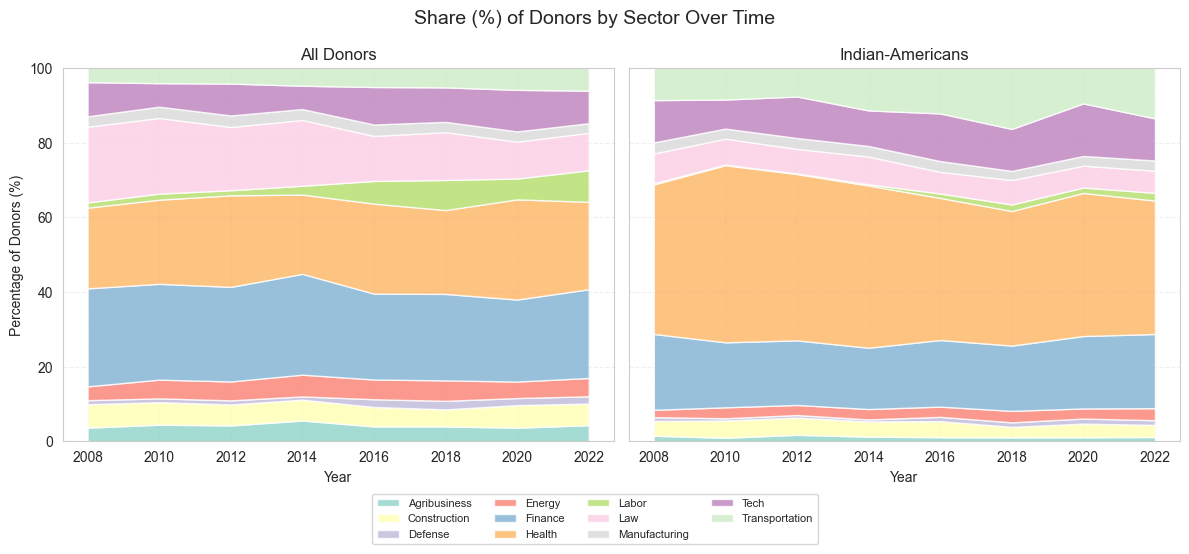

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
colors = sns.color_palette("Set3", n_colors=len(sector_pct_all.columns))

ax1.stackplot(
    sector_pct_all.index,
    sector_pct_all.T,
    labels=sector_pct_all.columns,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("All Donors", fontsize=12)
ax1.set_xlabel("Year")
ax1.set_ylabel("Percentage of Donors (%)")
ax1.set_ylim(0, 100)
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    sector_pct_indian.index,
    sector_pct_indian.T,
    labels=sector_pct_indian.columns,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans", fontsize=12)
ax2.set_xlabel("Year")
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Share (%) of Donors by Sector Over Time", fontsize=14)
plt.tight_layout()
plt.show()

In [20]:
sector_pct_all

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2008,3.646212,6.276544,1.087897,3.702599,26.246679,21.611728,1.412603,20.274168,2.773273,9.145027,3.823271
2010,4.444931,6.030088,1.019482,5.014300,25.663033,22.535064,1.615103,20.265635,3.026257,6.297623,4.088482
2012,4.244464,5.631901,1.082669,5.067977,25.328654,24.516457,1.367741,16.936305,3.085257,8.540414,4.198161
2014,5.562892,5.584900,0.867950,5.823628,27.001987,21.228183,2.369402,17.611952,2.923430,6.249274,4.776402
2016,3.983619,5.206854,2.069801,5.288458,23.002819,24.096457,6.070444,12.052940,3.062674,10.048661,5.117273
2018,3.971174,4.572577,2.292857,5.476767,23.155239,22.446338,8.080295,12.793524,2.757859,9.237350,5.216020
2020,3.647084,6.046741,1.880678,4.423844,21.959707,26.836277,5.581081,9.872022,2.738658,11.136246,5.877663
2022,4.311113,5.779269,1.968278,4.893090,23.774478,23.398635,8.444091,10.040170,2.572254,8.713366,6.105256


In [21]:
sector_pct_indian

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2008,1.476510,3.959732,1.033557,1.959732,20.322148,40.040268,0.308725,7.986577,2.953020,11.328859,8.630872
2010,0.950263,4.609786,0.606551,2.931662,17.408006,47.432268,0.161747,6.934897,2.709260,7.784068,8.471492
2012,1.728660,4.625656,0.679542,2.694325,17.298522,44.539819,0.166905,6.568908,2.920839,11.111111,7.665713
2014,1.233831,4.079602,0.537313,2.786070,16.417910,43.442786,0.358209,7.383085,2.845771,9.532338,11.383085
2016,1.097874,4.290275,1.160165,2.733006,17.838511,38.051857,1.183524,5.800825,2.888733,12.761816,12.193413
2018,1.033371,2.834661,1.204020,3.071672,17.491468,36.035267,1.753887,6.551005,2.436481,11.243838,16.344331
2020,1.082365,3.656283,1.346357,2.712513,19.396779,38.324974,1.438754,5.854013,2.606917,14.070750,9.510296
2022,1.147511,3.238941,1.258560,3.220433,19.868592,35.730150,2.072922,5.913381,2.748473,11.271516,13.529521


In [22]:
mean_all = all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])[~all_donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])].groupby(["cycle", "sector"])["dem_ratio"].mean().sort_values(ascending=False)
mean_ind = all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])[~all_donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])][all_donors["ethnic"].str.contains("ind", na=False)].groupby(["cycle", "sector"])["dem_ratio"].mean().sort_values(ascending=False)
mean_all = mean_all.unstack(level='sector')
mean_ind = mean_ind.unstack(level='sector')

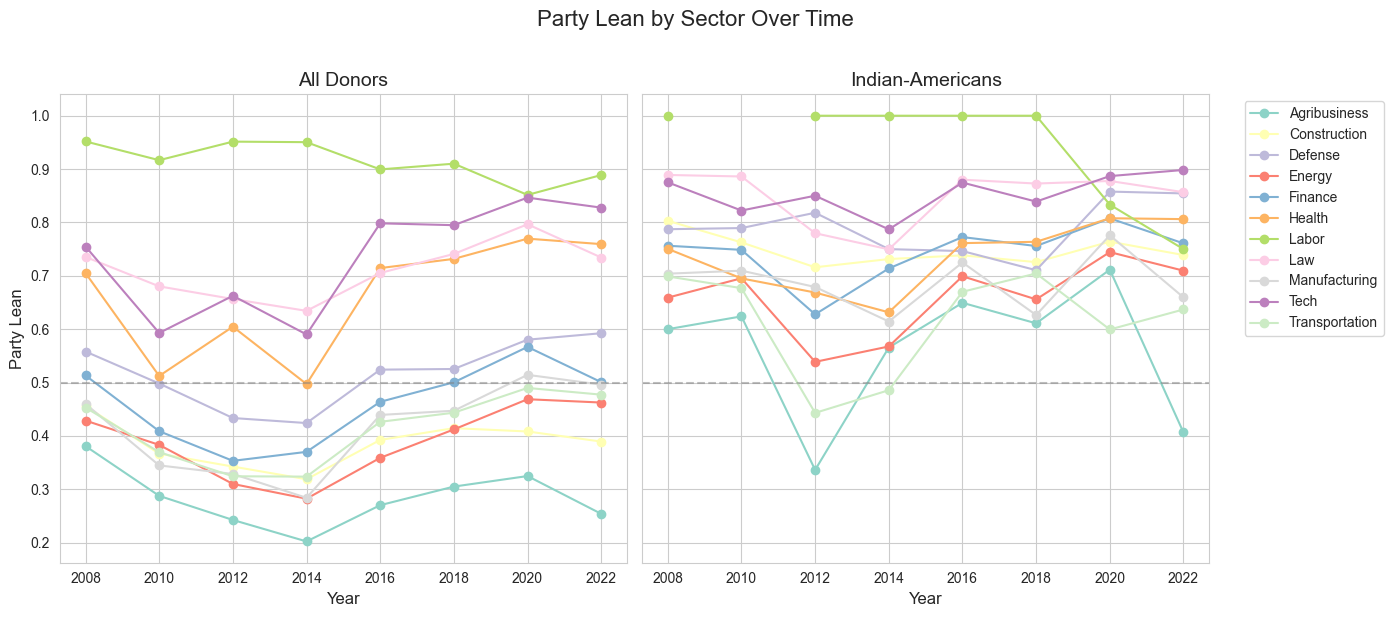

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")
sns.set_palette("Set3", n_colors=len(mean_all.columns))

for sector in mean_all.columns:
    ax1.plot(
        mean_all.index,
        mean_all[sector],
        marker='o',
        label=sector
    )
ax1.set_title('All Donors', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

for sector in mean_ind.columns:
    ax2.plot(
        mean_ind.index,
        mean_ind[sector],
        marker='o',
        label=sector
    )
ax2.set_title('Indian-Americans', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Party Lean by Sector Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [24]:
mean_all

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2008,0.380879,0.455862,0.558112,0.428751,0.513264,0.705198,0.951801,0.735398,0.459957,0.754924,0.453176
2010,0.287671,0.366756,0.498164,0.383166,0.408850,0.512333,0.916656,0.680231,0.344710,0.592879,0.369630
2012,0.242524,0.342568,0.433514,0.309983,0.353269,0.604654,0.951439,0.656536,0.328681,0.662542,0.324376
2014,0.202260,0.318789,0.424100,0.282369,0.370099,0.497155,0.950427,0.634316,0.283988,0.590126,0.323699
2016,0.270184,0.392460,0.524166,0.358912,0.463893,0.714490,0.899398,0.705307,0.439319,0.798348,0.426383
2018,0.305051,0.414535,0.525389,0.412130,0.500437,0.731709,0.910106,0.740961,0.447150,0.794879,0.443496
2020,0.324784,0.408297,0.580298,0.468752,0.566774,0.769636,0.851575,0.796578,0.514427,0.846527,0.489890
2022,0.253979,0.389415,0.592415,0.462518,0.500696,0.759400,0.888844,0.734308,0.496070,0.827765,0.477299


In [25]:
mean_ind

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2008,0.600000,0.803079,0.787317,0.659091,0.756334,0.750529,1.000000,0.888994,0.703999,0.875162,0.698886
2010,0.624000,0.762614,0.789474,0.695423,0.748648,0.695114,NaN,0.886128,0.709652,0.822318,0.676882
2012,0.336305,0.715992,0.818182,0.538741,0.627780,0.668675,1.000000,0.779794,0.679076,0.850080,0.443123
2014,0.565657,0.731386,0.750000,0.567609,0.713801,0.631562,1.000000,0.749625,0.614360,0.787046,0.485643
2016,0.649425,0.738386,0.746325,0.699160,0.772590,0.761247,1.000000,0.880103,0.724999,0.874665,0.670059
2018,0.610976,0.725673,0.710526,0.655830,0.755804,0.763714,1.000000,0.872881,0.626487,0.839087,0.704403
2020,0.711538,0.763982,0.857814,0.744421,0.807699,0.807861,0.833333,0.877717,0.775921,0.886863,0.599436
2022,0.406440,0.738953,0.854415,0.709600,0.760761,0.806233,0.750000,0.856680,0.659605,0.898346,0.636935


In [27]:
dollar_mean_all = (
    all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    [~all_donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])]
    .groupby(["cycle", "sector"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
    .unstack(level='sector')
)
dollar_mean_ind = (
    all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    [~all_donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])]
    [all_donors["ethnic"].str.contains("ind", na=False)]
    .groupby(["cycle", "sector"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
    .unstack(level='sector')
)

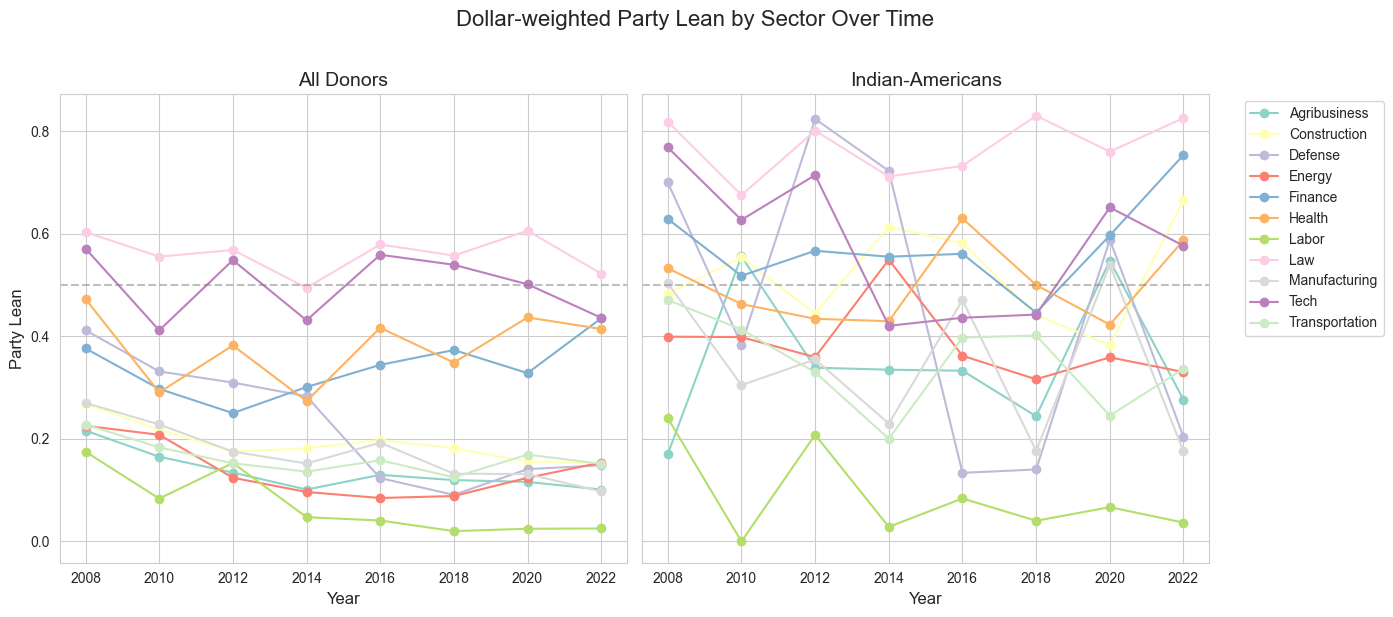

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")
sns.set_palette("Set3", n_colors=len(mean_all.columns))

for sector in dollar_mean_all.columns:
    ax1.plot(
        dollar_mean_all.index,
        dollar_mean_all[sector],
        marker='o',
        label=sector
    )
ax1.set_title('All Donors', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

for sector in dollar_mean_ind.columns:
    ax2.plot(
        dollar_mean_ind.index,
        dollar_mean_ind[sector],
        marker='o',
        label=sector
    )
ax2.set_title('Indian-Americans', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Dollar-weighted Party Lean by Sector Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [30]:
dollar_mean_all

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2008,0.216033,0.268090,0.411745,0.225475,0.376253,0.472776,0.174995,0.603075,0.269915,0.571038,0.227654
2010,0.165139,0.217960,0.331453,0.207890,0.297362,0.290515,0.083512,0.555164,0.228111,0.411485,0.183426
2012,0.134252,0.175080,0.309709,0.124228,0.250178,0.382058,0.152995,0.568227,0.175168,0.548334,0.152309
2014,0.101159,0.181598,0.282972,0.096365,0.301025,0.273568,0.047298,0.494469,0.151937,0.431092,0.136162
2016,0.129861,0.197655,0.123422,0.084700,0.344186,0.416506,0.040791,0.578949,0.192479,0.558894,0.158288
2018,0.119614,0.181719,0.090781,0.088493,0.373098,0.348744,0.020149,0.557245,0.132015,0.539332,0.124941
2020,0.115999,0.155684,0.141032,0.124059,0.328222,0.436698,0.024767,0.605734,0.131390,0.501263,0.169346
2022,0.101174,0.152276,0.148278,0.153769,0.435031,0.414164,0.025231,0.521944,0.097415,0.436088,0.151412


In [31]:
dollar_mean_ind

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2008,0.170210,0.483186,0.699794,0.399182,0.628644,0.532601,0.240298,0.818250,0.503465,0.768061,0.470743
2010,0.555635,0.553745,0.383766,0.398333,0.517833,0.462689,0.000000,0.675079,0.304565,0.626844,0.413147
2012,0.338707,0.443998,0.823610,0.359212,0.566649,0.434046,0.207994,0.800801,0.354844,0.714104,0.329693
2014,0.334767,0.613670,0.722444,0.549402,0.555030,0.429302,0.028361,0.711378,0.229715,0.420378,0.200376
2016,0.332847,0.581462,0.133719,0.361953,0.560731,0.629606,0.083806,0.732136,0.470679,0.436033,0.397349
2018,0.244087,0.441598,0.140243,0.316085,0.446109,0.499925,0.040279,0.829921,0.176699,0.442262,0.401543
2020,0.547137,0.382524,0.588281,0.358870,0.596565,0.422630,0.066794,0.759895,0.539285,0.651151,0.245275
2022,0.276309,0.665062,0.204081,0.330256,0.753440,0.586961,0.036756,0.825454,0.175363,0.576433,0.336520
